In [1]:
import os
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple, List
from collections import defaultdict

In [2]:
# Display all columns
pd.set_option("display.max_columns", None)

## Utils

This section includes general helper functions to produce our results.

In [3]:
def mean_std(values: List[float]) -> Tuple[float, float]:
    mean, stdev = statistics.mean(values), statistics.stdev(values)
    mean, stdev = round(mean * 100, 2), round(stdev * 100, 2)

    return mean, stdev

In [4]:
def best_run_test_metrics(results_folder: str, metric: str, ascending: bool = True) -> Tuple[pd.DataFrame, int]:
    """
        Given an output folder, a metric and whether the metric
        should increase/decrease return the test results of the best
        model on the validation set and the epoch this model was found
    """
    validation = pd.read_csv(os.path.join(results_folder, "val_eval.csv"))
    test = pd.read_csv(os.path.join(results_folder, "test_eval.csv"))

    index_function = "idxmax" if ascending else "idxmin"
    best_epoch = int(validation.iloc[getattr(validation[metric], index_function)(), :].epoch)

    return test[test["epoch"] == best_epoch], best_epoch

## Qualitative Results

The qualitative part of our experiments includes the comparison of **Group-DRO** and **CGD** on two toy datasets, **Simple** and **Simple-MNIST**, for three different multi-group setups: noisy, rotated, and spurious. In the original CGD paper, the three setups are analyzed in Sections 4.1, 4.2 and 4.3 in the same order.

For each multi-group setup we demonstrate two things:

* The focus each algorithm puts on each group. The focus is expressed by the weight (alpha) assigned to the loss of each group when calculating the final loss.
* The overall worst loss of each algorithm

### Utility functions

First we define a few utility functions used to average results over different seeds and plot alpha (group) weights

In [5]:
def average_qualitative_results(
    results_folder: str,
    algorithm: str,
    selection_metric: str,
    seeds: List[int],
    ascending: bool,
    out_metric: str
):
    """
        Given a dataset (root) result folder, the algorithm, metric, seeds and whether
        the metric should be ascending or descending this method extracts the output
        accuracy for each seed and returns the mean and standard deviation averaged
        over the given seeds

        - :param results_folder: root dataset results folder (whithout algorithm and seed)
        - :param algorithm: the algorithm results in analysis
        - :param selection_metric: the metric used for model selection
        - :param seeds: the result seeds
        - :param ascending: whether the best model selection metric is the highest or lowest
        - :param out_metric: the metric that should be returned
    """
    test_accuracies = []

    for seed in seeds:
        data_folder = os.path.join(results_folder, f"{algorithm}/{seed}")

        if not os.path.exists(data_folder):
            print(f"results folder {data_folder} does not exist")
            continue

        best_res, _ = best_run_test_metrics(
            results_folder=data_folder,
            metric=selection_metric,
            ascending=ascending
        )

        test_accuracies.append(best_res[out_metric].values[0])

    return mean_std(test_accuracies)

In [6]:
def plot_qualitative_alphas(
    root_folder: str,
    seed: int,
    algorithm: str,
    alpha_key: str,
    plot_ax,
    title: str = None
) -> None:
    """
        Plots the group weights (identified by the alpha_key parameter) over
        epochs for the root_folder/algorithm/seed result on a matplotlib ax
    """
    data_folder = os.path.join(os.path.join(root_folder, algorithm), str(seed))
    algo_train = pd.read_csv(os.path.join(data_folder, "train_algo.csv"))

    title = title if title is not None else algorithm
    plot_ax.set_title(title)
    
    plot_ax.plot(algo_train["epoch"], algo_train[f"{alpha_key}:0"])
    plot_ax.plot(algo_train["epoch"], algo_train[f"{alpha_key}:1"])
    plot_ax.plot(algo_train["epoch"], algo_train[f"{alpha_key}:2"])

    plot_ax.set_xlabel("epoch")
    plot_ax.set_ylabel("alpha")
    plot_ax.set_ylim([0, 1])

In [7]:
def plot_qualitative_alphas_average(
    root_folder: str,
    seeds: int,
    algorithm: str,
    alpha_key: str,
    plot_ax,
    title: str = None
) -> None:
    """
        Plots the group weights (identified by the alpha_key parameter) over
        epochs for the root_folder/algorithm/seed result on a matplotlib ax.
        The weights are averaged over the given seeds
    """
    g1 = []
    g2 = []
    g3 = []

    for seed in seeds:
        data_folder = os.path.join(os.path.join(root_folder, algorithm), str(seed))
        algo_train = pd.read_csv(os.path.join(data_folder, "train_algo.csv"))

        g1.append(algo_train[f"{alpha_key}:0"])
        g2.append(algo_train[f"{alpha_key}:1"])
        g3.append(algo_train[f"{alpha_key}:2"])

    title = title if title is not None else algorithm
    plot_ax.set_title(title)
        
    plot_ax.plot(algo_train["epoch"], np.mean(np.array(g1), axis=0))
    plot_ax.plot(algo_train["epoch"], np.mean(np.array(g2), axis=0))
    plot_ax.plot(algo_train["epoch"], np.mean(np.array(g3), axis=0))

    plot_ax.set_xlabel("epoch")
    plot_ax.set_ylabel("alpha")
    plot_ax.set_ylim([0, 1])

### Simple Dataset Results

Here we average the results for the three setups used for the **Simple** dataset and produce the table used in the paper

In [8]:
qualitative_results = {
    "algorithms": ["Group-DRO", "CGD"],
    "datasets": ["Noisy", "Rotation", "Spurious"]
}

In [9]:
results_table = []

for algorithm in ["groupDRO", "CGD"]:
    dataset_results = []

    for dataset_name in ["noisy_2feature", "rot_simple_2d", "spu_2feature"]:
        mean, std = average_qualitative_results(
            results_folder=f"results/qualitative/{dataset_name}/",
            algorithm=algorithm,
            selection_metric="loss_wg",
            out_metric="loss_wg",
            ascending=False,
            seeds=[0, 13, 3, 42, 5, 8]
        )

        # Un-normalize the mean and std since these
        # refer to losses, not accuracies
        mean, std = int(mean), int(std)
        mean, std = mean / 100.0, std / 100.0

        dataset_results.append(f"{mean} ({std})")

    results_table.append(dataset_results)

In [10]:
pd.DataFrame.from_records(
    results_table,
    index=qualitative_results["algorithms"],
    columns=qualitative_results["datasets"]
)

,Noisy,Rotation,Spurious
Group-DRO,0.26 (0.02),0.47 (0.04),0.42 (0.03)
CGD,0.22 (0.01),0.46 (0.06),0.32 (0.01)


### Simple Plots

Here we first replicate the plots used for the qualitative evaluation. We were able to create very similar plots for specific seeds, but different seeds may lead to different results. The second cell shows the plots averaged over six seeds.

The last plot is used in Appendix A, to show that CGD does not pick the center group consistently.

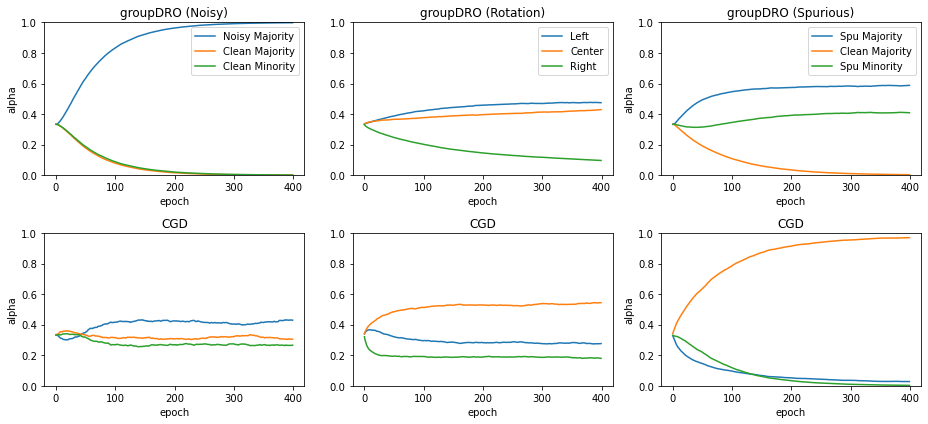

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 6))

# Simple Noisy
noisy_folder = "results/qualitative/noisy_2feature"

plot_qualitative_alphas(noisy_folder, 42, "groupDRO", "weight_group", axes[0][0], title="groupDRO (Noisy)")
plot_qualitative_alphas(noisy_folder, 42, "CGD", "alpha_group", axes[1][0])

# Simple Rotation
rotation_folder = "results/qualitative/rot_simple_2d"

plot_qualitative_alphas(rotation_folder, 3, "groupDRO", "weight_group", axes[0][1], title="groupDRO (Rotation)")
plot_qualitative_alphas(rotation_folder, 3, "CGD", "alpha_group", axes[1][1])

axes[0][1].set_ylabel("")
axes[1][1].set_ylabel("")

# Simple Spurious
spurious_folder = "results/qualitative/spu_2feature"

plot_qualitative_alphas(spurious_folder, 42, "groupDRO", "weight_group", axes[0][2], title="groupDRO (Spurious)")
plot_qualitative_alphas(spurious_folder, 42, "CGD", "alpha_group", axes[1][2])

fig.tight_layout()

axes[0][0].legend(["Noisy Majority", "Clean Majority", "Clean Minority"])
axes[0][1].legend(["Left", "Center", "Right"])
axes[0][2].legend(["Spu Majority", "Clean Majority", "Spu Minority"])

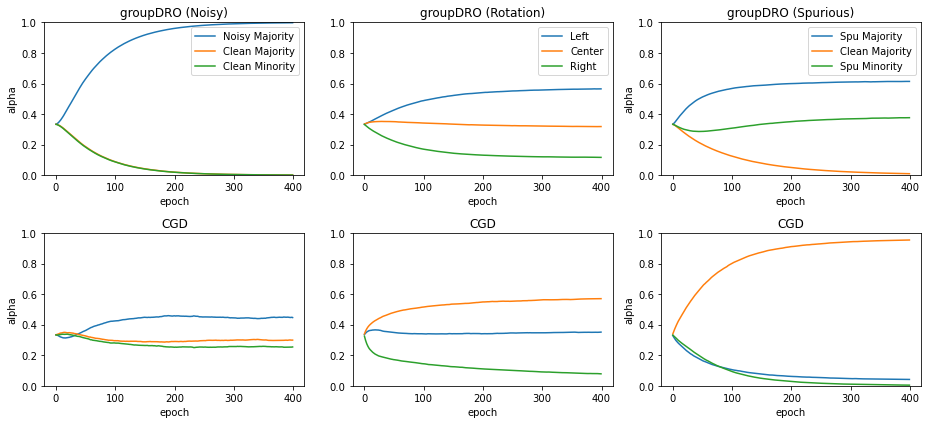

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 6))

seeds = [0, 3, 5, 8, 13, 42]

# Simple Noisy
noisy_folder = "results/qualitative/noisy_2feature"

plot_qualitative_alphas_average(noisy_folder, seeds, "groupDRO", "weight_group", axes[0][0], title="groupDRO (Noisy)")
plot_qualitative_alphas_average(noisy_folder, seeds, "CGD", "alpha_group", axes[1][0])

# Simple Rotation
rotation_folder = "results/qualitative/rot_simple_2d"

plot_qualitative_alphas_average(rotation_folder, seeds, "groupDRO", "weight_group", axes[0][1], title="groupDRO (Rotation)")
plot_qualitative_alphas_average(rotation_folder, seeds, "CGD", "alpha_group", axes[1][1])

axes[0][1].set_ylabel("")
axes[1][1].set_ylabel("")

# Simple Spurious
spurious_folder = "results/qualitative/spu_2feature"

plot_qualitative_alphas_average(spurious_folder, seeds, "groupDRO", "weight_group", axes[0][2], title="groupDRO (Spurious)")
plot_qualitative_alphas_average(spurious_folder, seeds, "CGD", "alpha_group", axes[1][2])

fig.tight_layout()

axes[0][0].legend(["Noisy Majority", "Clean Majority", "Clean Minority"])
axes[0][1].legend(["Left", "Center", "Right"])
axes[0][2].legend(["Spu Majority", "Clean Majority", "Spu Minority"])

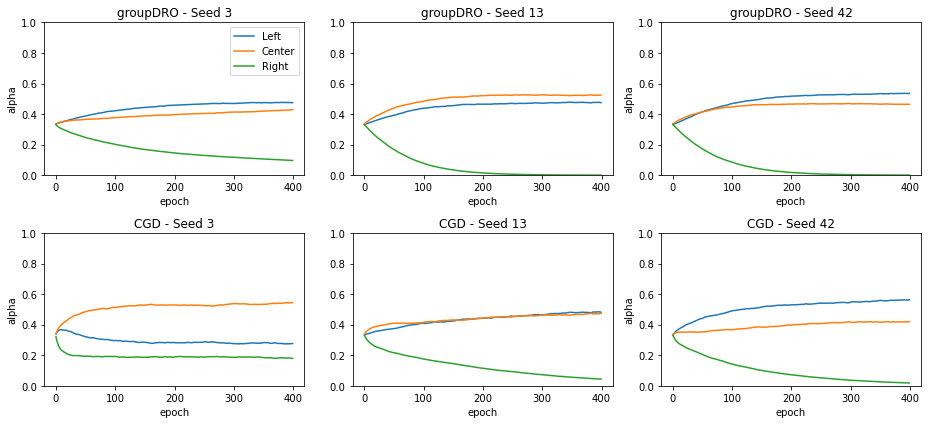

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 6))

# Simple Noisy
data_folder = "results/qualitative/rot_simple_2d"

plot_qualitative_alphas(data_folder, 3, "groupDRO", "weight_group", axes[0][0], title="groupDRO - Seed 3")
plot_qualitative_alphas(data_folder, 3, "CGD", "alpha_group", axes[1][0], title="CGD - Seed 3")

# Simple Rotation
plot_qualitative_alphas(data_folder, 13, "groupDRO", "weight_group", axes[0][1], title="groupDRO - Seed 13")
plot_qualitative_alphas(data_folder, 13, "CGD", "alpha_group", axes[1][1], title="CGD - Seed 13")

axes[0][1].set_ylabel("")
axes[1][1].set_ylabel("")

# Simple Spurious
plot_qualitative_alphas(data_folder, 42, "groupDRO", "weight_group", axes[0][2], title="groupDRO - Seed 42")
plot_qualitative_alphas(data_folder, 42, "CGD", "alpha_group", axes[1][2], title="CGD - Seed 42")

fig.tight_layout()

axes[0][0].legend(["Left", "Center", "Right"])

### Simple-MNIST Dataset Result

Here we average the results for the three setups used for the **Simple-MNIST** dataset and produce the table used in the paper. Each cell shows the average accuracy and the worst-group accuracy averages, along with their standard deviation in parenthesis

In [14]:
results_table = []

for algorithm in ["groupDRO", "CGD"]:
    dataset_results = []

    for dataset_name in ["noisy_mnist", "rot_mnist", "spu_mnist"]:
        params = {
            "results_folder": f"results/qualitative/{dataset_name}/",
            "algorithm": algorithm,
            "selection_metric": "acc_avg",
            "ascending": True,
            "seeds": [0, 13, 42]
        }

        acc_mean, acc_std = average_qualitative_results(**params, out_metric="acc_avg")
        acc_wg_mean, acc_wg_std = average_qualitative_results(**params, out_metric="acc_wg")

        dataset_results.append(f"{acc_mean} ({acc_std}), {acc_wg_mean} ({acc_wg_std})")

    results_table.append(dataset_results)

In [15]:
pd.DataFrame.from_records(
    results_table,
    index=qualitative_results["algorithms"],
    columns=qualitative_results["datasets"]
)

,Noisy,Rotation,Spurious
Group-DRO,"77.36 (10.02), 77.25 (9.95)","30.58 (3.82), 28.02 (4.42)","92.47 (2.63), 91.75 (2.68)"
CGD,"76.35 (7.8), 76.24 (7.81)","92.51 (1.78), 91.7 (2.35)","92.51 (1.78), 91.7 (2.35)"


## Quantitative Results

The quantitative part of our experiments compares **ERM**, **Group-DRO** and **CGD** on four non-WILDS datasets (two synthetic ones with induced spurious correlations and two real-world ones, with known spurious correlations) based on the average and worst-group accuracy, and four WILDS datasets based on a different metric for each dataset (average accuracy, worst-group pearson correlation coefficient, worst-region accuracy, and worst-group accuracy respectively).

### non-WILDS Results

Here we average the results for the non-WILDS datasets (CMNIST, WaterBirds, CelebA and MultiNLI) for **ERM**, **Group-DRO** and **CGD** and produce the table used in the report

In [16]:
non_wilds_datasets = ["CMNIST", "WaterBirds", "CelebA", "MultiNLI"]
non_wilds_algorithms = ["ERM", "groupDRO", "CGD"]

seeds = [0, 42, 13]
non_wilds_results = {}

for dataset in non_wilds_datasets:
    non_wilds_results[dataset] = {}

    for algorithm in non_wilds_algorithms:
        non_wilds_results[dataset][algorithm]  = {}

        test_avg_acc_arr = []  # Test average accuracies of the current dataset-algorithm pair for all seeds
        test_wg_acc_arr = []  # Test worst group accuracies of the current dataset-algorithm pair for all seeds

        for seed in seeds:
            # Read result files of dataset-algoirthm pair
            val_results = pd.read_csv(f"results/quantitative/{dataset}/{algorithm}/{seed}/val_eval.csv")
            test_results = pd.read_csv(f"results/quantitative/{dataset}/{algorithm}/{seed}/test_eval.csv")

            # Get best epoch (highest average val accuracy)
            if dataset == "WaterBirds":  # Depending on the dataset, set the name of the column where the average accuracy is found
                acc_avg_label = "adj_acc_avg"
            else:
                acc_avg_label = "acc_avg"
            best_epoch = int(val_results[acc_avg_label].idxmax())

            # Get test accuracy (avg and worst) for current seed
            test_avg_acc_arr.append(test_results.iloc[best_epoch][acc_avg_label])
            test_wg_acc_arr.append(test_results.iloc[best_epoch]['acc_wg'])

        # Get average test accuracies across all seeds
        non_wilds_results[dataset][algorithm]["test_avg_acc"] = {}
        non_wilds_results[dataset][algorithm]["test_avg_acc"]["value"] = round(100 * sum(test_avg_acc_arr) / len(test_avg_acc_arr),1)
        non_wilds_results[dataset][algorithm]["test_avg_acc"]["std"] = round(np.std(test_avg_acc_arr) * 100, 2)
        
        non_wilds_results[dataset][algorithm]["test_wg_acc"] = {}
        non_wilds_results[dataset][algorithm]["test_wg_acc"]["value"] = round(100 * sum(test_wg_acc_arr) / len(test_wg_acc_arr),1)
        non_wilds_results[dataset][algorithm]["test_wg_acc"]["std"] = round(np.std(test_wg_acc_arr) * 100, 2)

# Print table
non_wilds_df = pd.DataFrame(index=non_wilds_algorithms, columns=non_wilds_datasets)
for dataset in non_wilds_datasets:
    for algorithm in non_wilds_algorithms:
        non_wilds_df._set_value(
            algorithm,
            dataset,
            f"{non_wilds_results[dataset][algorithm]['test_avg_acc']['value']} ({non_wilds_results[dataset][algorithm]['test_avg_acc']['std'] }), {non_wilds_results[dataset][algorithm]['test_wg_acc']['value']} ({non_wilds_results[dataset][algorithm]['test_wg_acc']['std'] })"
        )

non_wilds_df

,CMNIST,WaterBirds,CelebA,MultiNLI
ERM,"55.3 (2.23), 10.5 (4.47)","97.1 (0.03), 52.2 (1.18)","96.0 (0.12), 36.3 (6.04)","62.2 (11.27), 16.1 (18.59)"
groupDRO,"97.6 (0.49), 96.8 (0.69)","97.3 (0.06), 71.7 (0.55)","94.9 (0.11), 59.1 (1.72)","49.9 (0.76), 27.5 (2.62)"
CGD,"98.0 (0.34), 97.0 (0.4)","97.3 (0.13), 73.2 (0.39)","95.0 (0.13), 59.8 (8.72)","50.2 (1.01), 27.1 (1.36)"


### WILDS Results

Here we average the results for the WILDS datasets (Camelyon17, PovertyMap, FMoW and CivilComments) for **CGD** and produce the table used in the report

In [17]:
metrics = ["acc_avg", "r_wg", "r_wg", "acc_worst_region", "acc_wg"]
wilds_datasets = ["Camelyon17", "PovertyMap (ID)", "PovertyMap", "FMoW", "CivilComments"]

# Table column labels
wilds_datasets_labels = [
    "Camelyon17 (OOD) Avg. Accuracy",
    "PovertyMap (ID) W.r. Pearson r",
    "PovertyMap (OOD) W.r. Pearson r",
    "FMoW (OOD) W.r. Accuracy",
    "CivilComments (OOD) W.g. Accuracy"
]

seeds = [0, 42, 13]
wilds_algorithms = ["CGD"]
wilds_results = {}

for index, dataset in enumerate(wilds_datasets):
    wilds_results[dataset] = {}

    for algorithm in wilds_algorithms:
        wilds_results[dataset][algorithm]  = {}

        # Test average for the respective metric of
        # the current dataset-algorithm pair for all seeds
        test_metric_arr = []  

        for seed in seeds:
            # Evaluate both ID and OOD sets
            if dataset == "PovertyMap (ID)":
                # Read result files of dataset-algorithm pair
                val_results = pd.read_csv(f"results/quantitative/PovertyMap/{algorithm}/{seed}/id_val_eval.csv")
                test_results = pd.read_csv(f"results/quantitative/PovertyMap/{algorithm}/{seed}/id_test_eval.csv")
            else:
                val_results = pd.read_csv(f"results/quantitative/{dataset}/{algorithm}/{seed}/val_eval.csv")
                test_results = pd.read_csv(f"results/quantitative/{dataset}/{algorithm}/{seed}/test_eval.csv")

            # Get best epoch (highest average val accuracy)
            acc_avg_label = metrics[index]
            best_epoch = int(val_results[acc_avg_label].idxmax())

            # Get test accuracy (avg and worst) for current seed
            test_metric_arr.append(test_results.iloc[best_epoch][acc_avg_label])

        # Get average test accuracies across all seeds
        if "PovertyMap" not in dataset: #For povertyMap the result is not given in percentage
            wilds_results[dataset][algorithm]["test_metric"] = round(100 * statistics.mean(test_metric_arr), 1)
            wilds_results[dataset][algorithm]["std"] = round(np.std(test_metric_arr) * 100, 2)
        else:
            wilds_results[dataset][algorithm]["test_metric"] = round(np.mean(test_metric_arr), 2)
            wilds_results[dataset][algorithm]["std"] = round(np.std(test_metric_arr), 2)

# Print table
wilds_df = pd.DataFrame(index=wilds_algorithms, columns=wilds_datasets_labels)
wilds_df.style.set_table_styles([dict(selector="th",props=[("max-width", "10px")])])  # Set wrapping limit

for i, dataset in enumerate(wilds_datasets):
    for algorithm in wilds_algorithms:
        wilds_df._set_value(
            algorithm,
            wilds_datasets_labels[i],
            f"{wilds_results[dataset][algorithm]['test_metric']} ({wilds_results[dataset][algorithm]['std']})"
        )

wilds_df

,Camelyon17 (OOD) Avg. Accuracy,PovertyMap (ID) W.r. Pearson r,PovertyMap (OOD) W.r. Pearson r,FMoW (OOD) W.r. Accuracy,CivilComments (OOD) W.g. Accuracy
CGD,70.4 (7.56),0.63 (0.03),0.38 (0.07),29.8 (1.46),69.7 (1.09)


## Results Beyond the Original Paper

In this section we produce plots to evaluate the following claim made by the paper:

> We show that CGD is a sound optimization algorithm as it monotonically decreases the macro/group-average loss, and consequently finds first order stationary points

The authors show that it holds with a mathematical proof, but do not evaluate it empirically. We compare the monotonicity of the decrease in training and validation loss between Group-DRO and CGD on CMNIST, WaterBirds and CelebA.

We also investigate the algorithm's sensitivity to hyperparameters on CMNIST.

In [18]:
def get_loss_curve(dataset: str, non_wilds_datasets: List[str], seeds: List[int]):
    """
        Average train and validation losses for the given dataset
        across the provided seeds
    """
    # Average CGD across seeds
    cgd_train_results = pd.concat([
        pd.read_csv(f"results/quantitative/{dataset}/CGD/{seed}/train_algo.csv")
        for seed in seeds
    ]).groupby([
        "epoch",
        "batch"
    ]).mean()

    cgd_val_results = pd.concat([
        pd.read_csv(f"results/quantitative/{dataset}/CGD/{seed}/val_algo.csv")
        for seed in seeds
    ]).groupby(["epoch"]).mean()

    # Average GDRO across seeds if
    # GDRO results are available
    if dataset in non_wilds_datasets:
        gdro_train_results = pd.concat([
            pd.read_csv(f"results/quantitative/{dataset}/groupDRO/{seed}/train_algo.csv")
            for seed in seeds
        ]).groupby(["epoch","batch"]).mean()

        gdro_val_results = pd.concat([
            pd.read_csv(f"results/quantitative/{dataset}/groupDRO/{seed}/val_algo.csv")
            for seed in seeds
        ]).groupby(["epoch"]).mean()

    # Get losses
    loss_columns = [column for column in cgd_train_results.columns if "loss_group" in column]

    # CGD
    # Get only the values for each epoch and not step
    cgd_train_losses = cgd_train_results.groupby("epoch").nth(1)[loss_columns].mean(axis=1).values
    cgd_val_losses = cgd_val_results[loss_columns].mean(axis=1).values

    # GDRO
    gdro_train_losses = None
    gdro_val_losses = None

    if dataset in non_wilds_datasets:
        gdro_train_losses = gdro_train_results.groupby("epoch").nth(1)[["loss_group:0","loss_group:1"]].mean(axis=1).values
        gdro_val_losses = gdro_val_results[["loss_group:0","loss_group:1"]].mean(axis=1).values

    return cgd_train_losses, cgd_val_losses, gdro_train_losses, gdro_val_losses

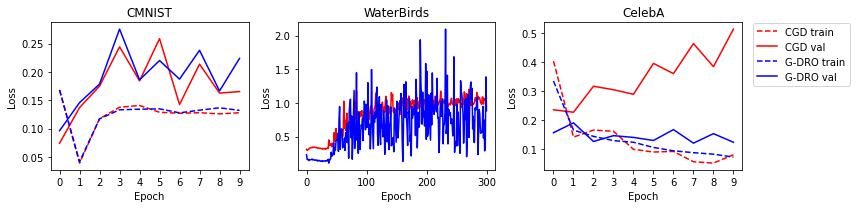

In [19]:
seeds = [0, 42, 13]
datasets = ["CMNIST", "WaterBirds", "CelebA"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

for i, dataset in enumerate(datasets):
    cgd_train_losses, cgd_val_losses, gdro_train_losses, gdro_val_losses = get_loss_curve(
        dataset,
        non_wilds_datasets,
        seeds
    )

    axes[i].set_title(dataset)
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Loss")
    
    if dataset != "WaterBirds":
        axes[i].set_xticks(np.arange(10))

    axes[i].plot(cgd_train_losses, "r--")
    axes[i].plot(cgd_val_losses, "r")
    axes[i].plot(gdro_train_losses, "b--")
    axes[i].plot(gdro_val_losses, "b")

    if i == 2:
        axes[i].legend(
            ["CGD train", "CGD val", "G-DRO train", "G-DRO val"],
            loc="upper left",
            bbox_to_anchor=(1.03,1.03)
        )

fig.tight_layout()
plt.show()

### Hyperparameter Sensitivity

In this subsection we investigate the sensitivity of CGD to the $C$ and $\eta$ (step size) hyperparameters using CMNIST as follows:

- $C$: fix $\eta = 0.05$, evaluate the algorithm on $\{0, 1, 2, 5, 10, 20\}$
- $\eta$: fix $C = 2$, evaluate the algorithm on $\{1, 0.1, 0.05, 0.01, 0.001\}$

We decided to pick $C = 2$ due to the fact that in our preliminary experiments it achieved a level of accuracy similar to the best parameter and showed a more stable training in comparison to $C = 0$ or $C = 1$. The results are averaged over three seeds $\{0, 13, 40\}$

In [20]:
def average_cmnist_train_eval_metrics(root_dir: str, n_epochs: int = 10):
    results = defaultdict(dict)
    step_sizes = [x for x in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, x))]
    
    for step_size in step_sizes:
        step_size_dir = os.path.join(root_dir, step_size)

        seeds = [x for x in os.listdir(step_size_dir) if os.path.isdir(os.path.join(step_size_dir, x))]        

        # Sum the results for all seeds given a particular step size
        acc_avgs_val, acc_wgs_val = np.zeros(n_epochs), np.zeros(n_epochs)
        acc_avgs_train, acc_wgs_train = np.zeros(n_epochs), np.zeros(n_epochs)
        acc_avgs_test, acc_wgs_test = np.zeros(n_epochs), np.zeros(n_epochs)
        
        for seed in seeds:
            data_dir = os.path.join(step_size_dir, seed)
    
            train_df = pd.read_csv(os.path.join(data_dir, "train_eval.csv"))
            val_df = pd.read_csv(os.path.join(data_dir, "val_eval.csv"))
            test_df = pd.read_csv(os.path.join(data_dir, "test_eval.csv"))

            acc_wgs_train = acc_wgs_train + train_df["acc_wg"].to_numpy()
            acc_avgs_train = acc_avgs_train + train_df["acc_avg"].to_numpy()
            
            acc_wgs_val = acc_wgs_val + val_df["acc_wg"].to_numpy()
            acc_avgs_val = acc_avgs_val + val_df["acc_avg"].to_numpy()
            
            acc_wgs_test = acc_wgs_test + test_df["acc_wg"].to_numpy()
            acc_avgs_test = acc_avgs_test + test_df["acc_avg"].to_numpy()

        # Average metrics
        results[step_size] = {
            "acc_wgs_val": acc_wgs_val / len(seeds),
            "acc_avgs_val": acc_avgs_val / len(seeds),
            "acc_wgs_train": acc_wgs_train / len(seeds),
            "acc_avgs_train": acc_avgs_train / len(seeds),
            "acc_wgs_test": acc_wgs_test / len(seeds),
            "acc_avgs_test": acc_avgs_test / len(seeds)
        }

    return results

In [21]:
cmnist_c_metrics = average_cmnist_train_eval_metrics(
    "results/quantitative/CMNIST-HyperParameters/C"
)

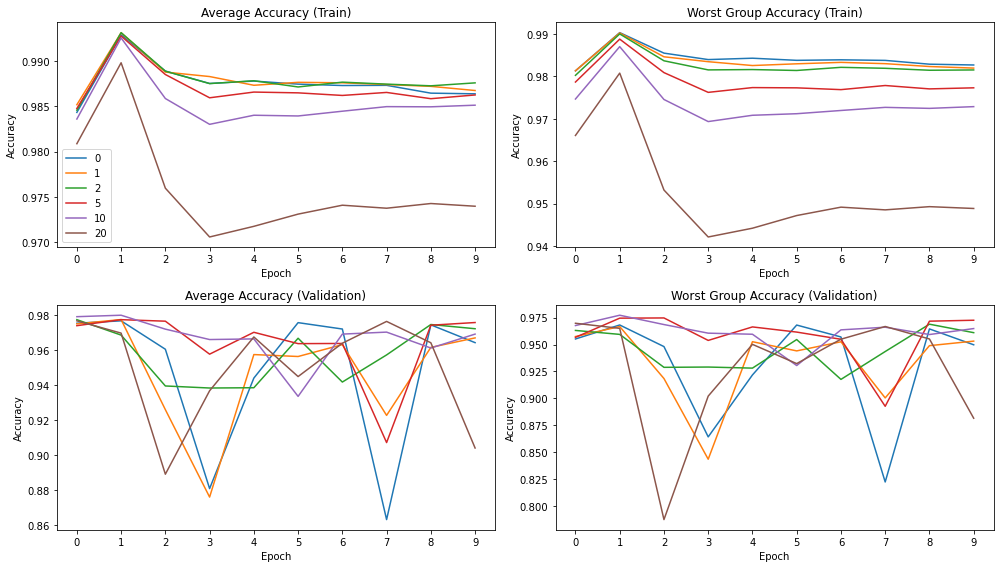

In [22]:
epochs, legend = np.arange(10), []

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
cmnist_c_values = sorted([int(x) for x in list(cmnist_c_metrics.keys())])

for c in cmnist_c_values:
    c = str(c)
    legend.append(c)
    c_metrics = cmnist_c_metrics[c]

    axes[0][0].plot(epochs, c_metrics["acc_avgs_train"])
    axes[0][1].plot(epochs, c_metrics["acc_wgs_train"])

    axes[1][0].plot(epochs, c_metrics["acc_avgs_val"])
    axes[1][1].plot(epochs, c_metrics["acc_wgs_val"])

for ax in axes.flatten():
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")

    ax.set_xticks(epochs)

axes[0][0].legend(cmnist_c_values, loc="lower left")

axes[0][0].set_title("Average Accuracy (Train)")
axes[1][0].set_title("Average Accuracy (Validation)")
axes[0][1].set_title("Worst Group Accuracy (Train)")
axes[1][1].set_title("Worst Group Accuracy (Validation)")
    
plt.tight_layout()

In [23]:
c_index, c_avg_test, c_wg_test = [], [], []

for c in cmnist_c_values:
    best_epoch = cmnist_c_metrics[str(c)]["acc_avgs_val"].argmax()
    
    test_avg_acc = cmnist_c_metrics[str(c)]["acc_avgs_test"][best_epoch]
    test_wg_acc = cmnist_c_metrics[str(c)]["acc_wgs_test"][best_epoch]
    
    c_index.append(c)
    c_avg_test.append(test_avg_acc)
    c_wg_test.append(test_wg_acc)

c_data = np.array([c_index, c_avg_test, c_wg_test])

pd.DataFrame(c_data.T, columns=["C", "acc_avg", "acc_wg"])

,C,acc_avg,acc_wg
0,0.0,0.973533,0.964333
1,1.0,0.973667,0.962267
2,2.0,0.975967,0.963067
3,5.0,0.974900,0.971867
4,10.0,0.975533,0.972267
5,20.0,0.973900,0.965867


Sentitivity to the step size parameter $\eta$

In [24]:
def step_size_to_float(step_size_string: str):
    zeros_count = len([x for x in step_size_string if x == "0"])

    return float(step_size_string) / (10 ** zeros_count)

In [25]:
cmnist_step_size_metrics = average_cmnist_train_eval_metrics(
    "results/quantitative/CMNIST-HyperParameters/step_size"
)

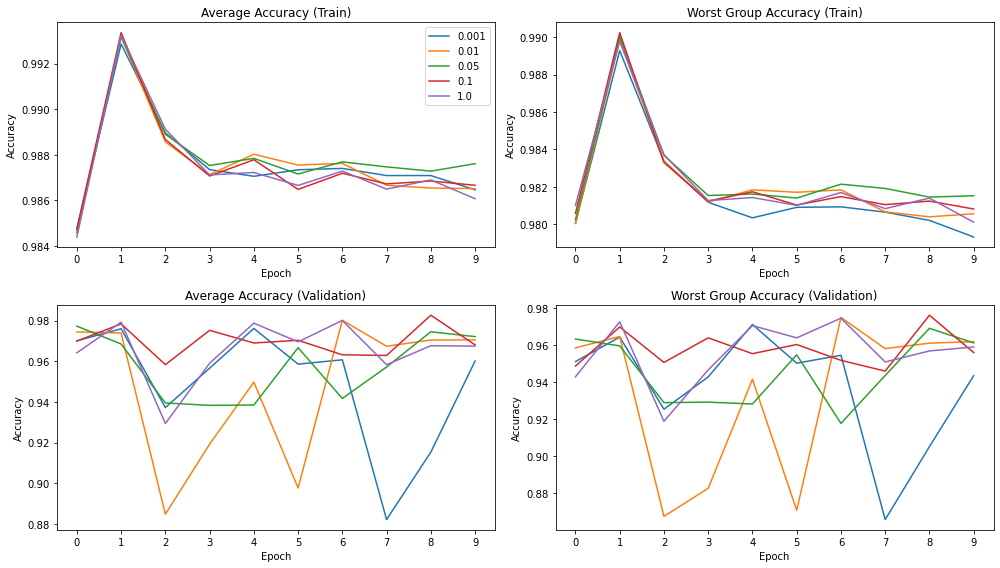

In [26]:
epochs, legend = np.arange(10), []
 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
cmnist_step_sizes = sorted(list(cmnist_step_size_metrics.keys()))

for step_size in cmnist_step_sizes:
    legend.append(step_size)
    step_size_values = cmnist_step_size_metrics[step_size]

    axes[0][0].plot(epochs, step_size_values["acc_avgs_train"])
    axes[0][1].plot(epochs, step_size_values["acc_wgs_train"])

    axes[1][0].plot(epochs, step_size_values["acc_avgs_val"])
    axes[1][1].plot(epochs, step_size_values["acc_wgs_val"])

for ax in axes.flatten():
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")

    ax.set_xticks(epochs)

axes[0][0].legend([step_size_to_float(v) for v in cmnist_step_sizes], loc="upper right")

axes[0][0].set_title("Average Accuracy (Train)")
axes[1][0].set_title("Average Accuracy (Validation)")
axes[0][1].set_title("Worst Group Accuracy (Train)")
axes[1][1].set_title("Worst Group Accuracy (Validation)")
    
plt.tight_layout()

In [27]:
step_size_index, step_size_avg_test, step_size_wg_test = [], [], []

for step_size in cmnist_step_sizes:
    best_epoch = cmnist_step_size_metrics[step_size]["acc_avgs_val"].argmax()
    
    test_avg_acc = cmnist_step_size_metrics[step_size]["acc_avgs_test"][best_epoch]
    test_wg_acc = cmnist_step_size_metrics[step_size]["acc_wgs_test"][best_epoch]
    
    step_size_index.append(step_size_to_float(step_size))
    step_size_avg_test.append(test_avg_acc)
    step_size_wg_test.append(test_wg_acc)

step_size_data = np.array([
    step_size_index,
    step_size_avg_test,
    step_size_wg_test
])

pd.DataFrame(step_size_data.T, columns=["step_size", "acc_avg", "acc_wg"])

,step_size,acc_avg,acc_wg
0,0.001,0.973300,0.968133
1,0.010,0.978267,0.973733
2,0.050,0.975967,0.963067
3,0.100,0.979567,0.972400
4,1.000,0.978167,0.971333
